# SeaFlow data (regridded)

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/SeaFlow_SizeDist_regrid-15-5.nc'

data_seaflow = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_seaflow[var] = nc.variables[var][:]

In [2]:
v_min = data_seaflow['v_min']
delta_v = 1.0/data_seaflow['delta_v_inv']
v = v_min * 2**(np.arange(data_seaflow['m'])*delta_v) 

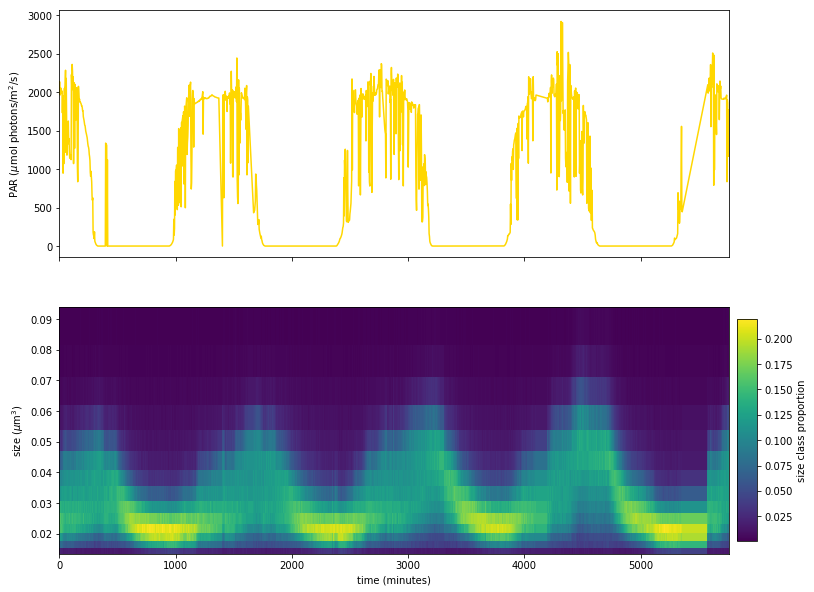

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_seaflow['time'], data_seaflow['PAR'], color='gold')
ax.set(ylabel='PAR ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data_seaflow['time'],v,data_seaflow['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [4]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_seaflow[k]

data['obs'] = data_seaflow['w_obs']
data['t_obs'] = data_seaflow['time']
data['E'] = data_seaflow['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_seaflow['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 20

# remove very first observations
ind_obs = data['t_obs'] > 3
data['t_obs'] = data['t_obs'][ind_obs]
data['obs'] = data['obs'][:,ind_obs]

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]
    
# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_seaflow['time'], fp=data_seaflow['PAR'])

In [5]:
import pystan

modelfiles = {
    'norm':'stancode/matrixmodel_sigmoidaldelta_normparam.stan',
    'trackgrowth':'stancode/matrixmodel_sigmoidaldelta_normparam_trackgrowth.stan',
}

desc = {
    'norm':'model with normalized population',
    'trackgrowth':'model with "growing population"',
}

models = {name:pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False) for name in modelfiles}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL norm NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL trackgrowth NOW.


In [6]:
mcmc = {}
for name in models:
    mcmc[name] = models[name].sampling(data=data, iter=2000)
    print('\n'.join(x for x in mcmc[name].__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: norm.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           4.35    0.03    1.0   2.88   3.65   4.19   4.83   6.86    951   1.01
gamma_max           2.25    0.02   0.63   1.61   1.84    2.0   2.47   3.92    758   1.01
sig_offset          0.04  1.0e-4 2.9e-3   0.03   0.03   0.04   0.04   0.04    850   1.01
sig_steepness     212.58    2.07   65.4 114.54  165.5 202.08 248.84 370.88    997   1.01
E_star            772.17   29.88 784.77  40.55 165.69 418.16 1219.9 2773.9    690   1.01
sigma               0.11  1.5e-4 6.3e-3    0.1   0.11   0.11   0.12   0.13   1869    1.0
lp__              -137.4    0.05   1.78 -141.9 -138.3 -137.0 -136.1 -135.0   1379    1.0

Samples were drawn using NUTS at Tue Feb  4 15:41:03 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rha

Inference for Stan model: trackgrowth.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           4.36    0.03   0.98    2.9   3.66   4.18   4.89   6.84   1057    1.0
gamma_max           2.23    0.02   0.63    1.6   1.84   1.99   2.43   4.03    800    1.0
sig_offset          0.04  8.9e-5 2.8e-3   0.03   0.03   0.04   0.04   0.04   1013    1.0
sig_steepness     211.88    1.91  64.99 118.05 164.31 201.52 248.26 370.17   1152    1.0
E_star            752.66   28.26 770.14  36.96 166.34 418.69 1169.8 2689.9    743    1.0
sigma               0.11  1.4e-4 6.2e-3    0.1   0.11   0.11   0.12   0.13   1934    1.0
lp__              -137.3    0.04   1.74 -141.6 -138.2 -136.9 -136.0 -134.9   1501    1.0

Samples were drawn using NUTS at Tue Feb  4 15:43:29 2020.
For each parameter, n_eff is a crude measure of effective sample size,


## Compare parameter estimates of the two models (they should be the same)

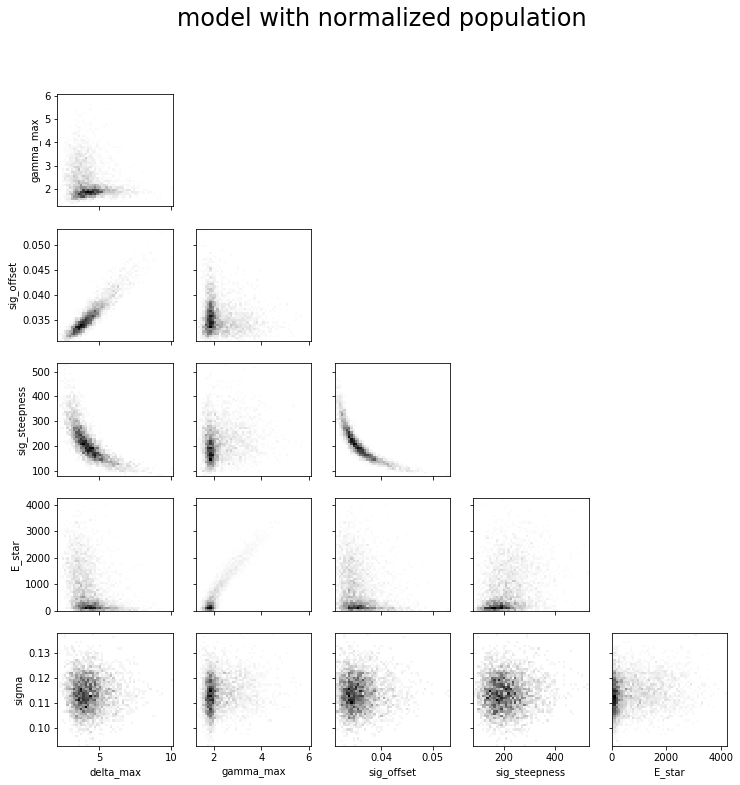

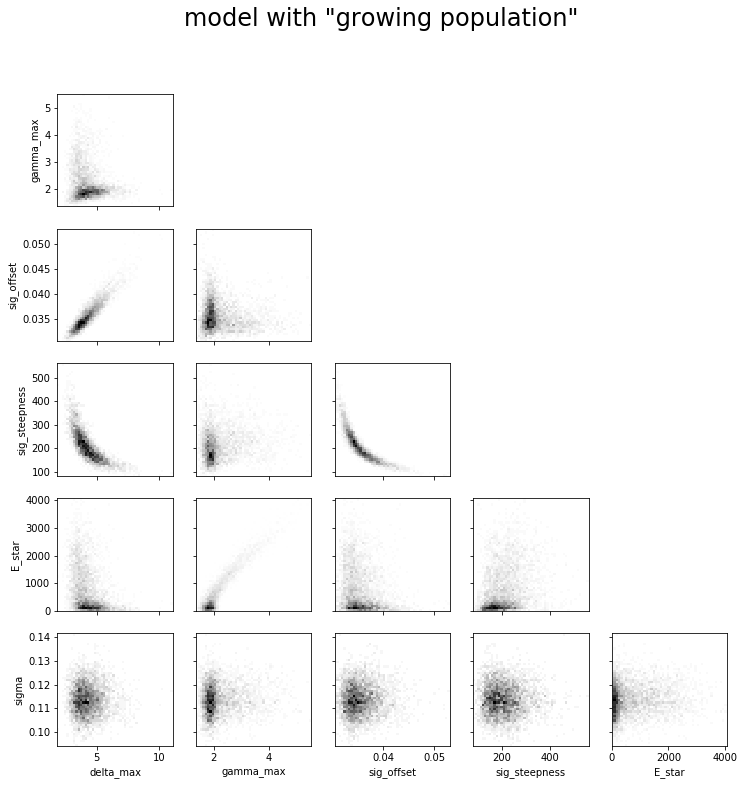

In [7]:
paramnames = [v for v in mcmc[list(models.keys())[0]].flatnames if not v.startswith('mod_obspos')]
num_params = len(paramnames)

for name in models:
    fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
    for ax in axs.flat:
        ax.set_visible(False)
    for irow in range(1,num_params):
        for icol in range(irow):
            ax = axs[irow-1,icol]
            ax.set_visible(True)
            xname = paramnames[icol]
            yname = paramnames[irow]
            ax.hist2d(mcmc[name][xname],mcmc[name][yname],bins=50,cmap=mpl.cm.gray_r)
            if icol == 0:
                ax.set_ylabel(yname)
            if irow == num_params-1:
                ax.set_xlabel(xname)
    fig.suptitle(desc[name], size=24)

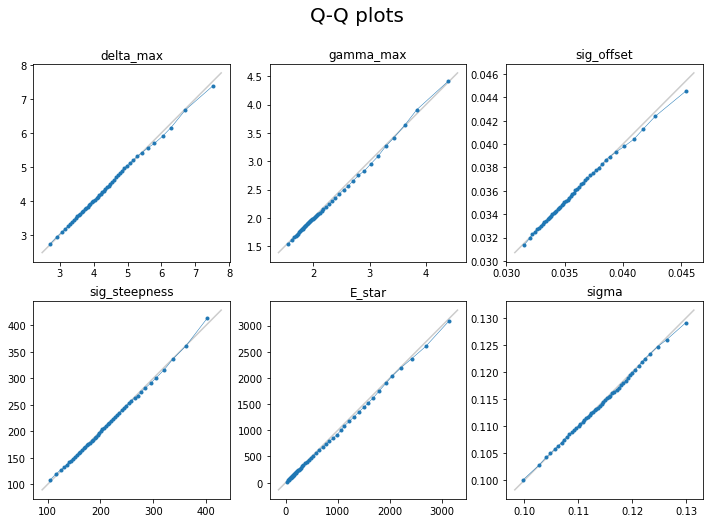

In [8]:
ncols = 3
nrows = int(np.ceil(num_params/ncols))

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,12/ncols*nrows))
for ax in axs.flat:
    ax.set_visible(False)
q = np.arange(1,100,2)
for paramname,ax in zip(paramnames,axs.flat):
    qx = np.percentile(mcmc['norm'][paramname], axis=0, q=q)
    qy = np.percentile(mcmc['trackgrowth'][paramname], axis=0, q=q)

    ax.set_visible(True)
    ax.plot(qx,qy,marker='.',lw=0.5)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = (min(xlim[0],ylim[0]), max(xlim[1],ylim[1]))
    ax.plot(lim,lim,color='0.8', zorder=0)
    
    ax.set(title=paramname)
fig.suptitle('Q-Q plots', size=20)
None

## Plot state estimates and growth

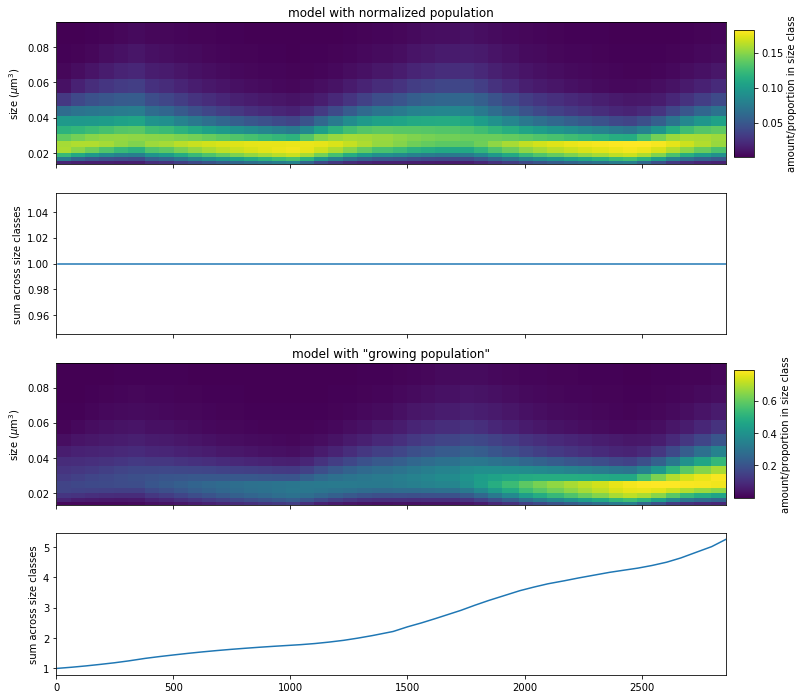

In [9]:
fig,axs = plt.subplots(nrows=4,sharex=True,figsize=(12,12))

for imodel,name in enumerate(models):
    mean = np.mean(mcmc[name]['mod_obspos'], axis=0)
    
    ax = axs[2*imodel]
    pc = ax.pcolormesh(data['t_obs'],v,mean)
    ax.set(ylabel='size ($\mu$m$^3$)', title=desc[name])
    add_colorbar(ax, label='amount/proportion in size class', norm=pc.norm)
    
    ax = axs[2*imodel+1]
    ax.plot(data['t_obs'], np.sum(mean, axis=0))
    ax.set(ylabel='sum across size classes')
axs[-1].set_xlim([0,data['t_obs'][-1]])
None

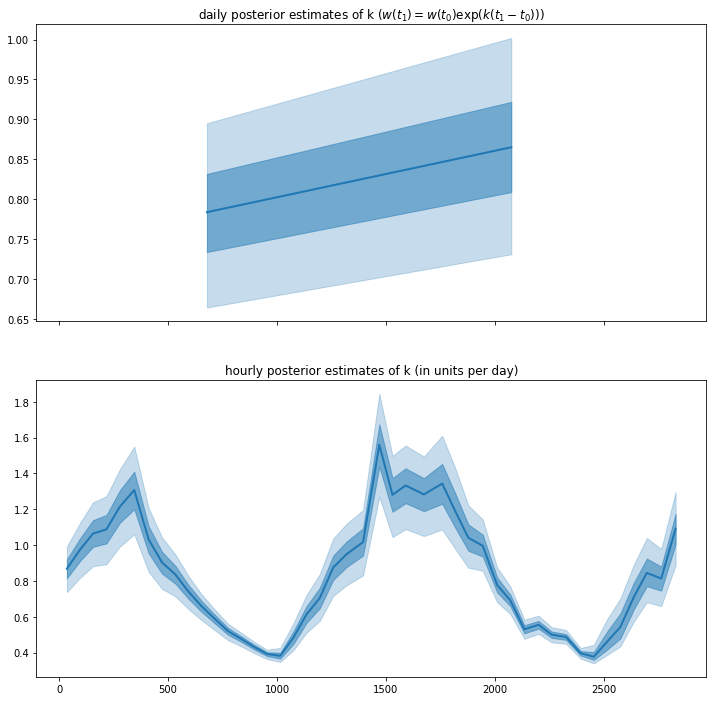

In [17]:
dt_obs = data['t_obs'][1]-data['t_obs'][0]

# cheat a little: the -2 is used to get two roughly daily estimates
ndt = {'day':1440//dt_obs-2, 'hour':60//dt_obs}

sum_pop = np.sum(mcmc[name]['mod_obspos'], axis=1)

fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
for ax,key in zip(axs,ndt):
    t = data['t_obs'][::ndt[key]]
    tmp = sum_pop[:,::ndt[key]]
    tmp = tmp[:,1:] / tmp[:,:-1]
    k = np.log(tmp)/((t[1:]-t[:-1])/1440.0)

    q = np.percentile(k, q=(5,25,50,75,95), axis=0)

    t_mid = 0.5*(t[1:]+t[:-1])

    ax.fill_between(t_mid, q[0,:], q[-1,:], color='C0', alpha=0.25)
    ax.fill_between(t_mid, q[1,:], q[-2,:], color='C0', alpha=0.5)
    ax.plot(t_mid, q[2,:], color='C0', lw=2)
axs[0].set_title('daily posterior estimates of k ($w(t_1) = w(t_0)\exp(k (t_1-t_0))$)')
axs[1].set_title('hourly posterior estimates of k (in units per day)')
None

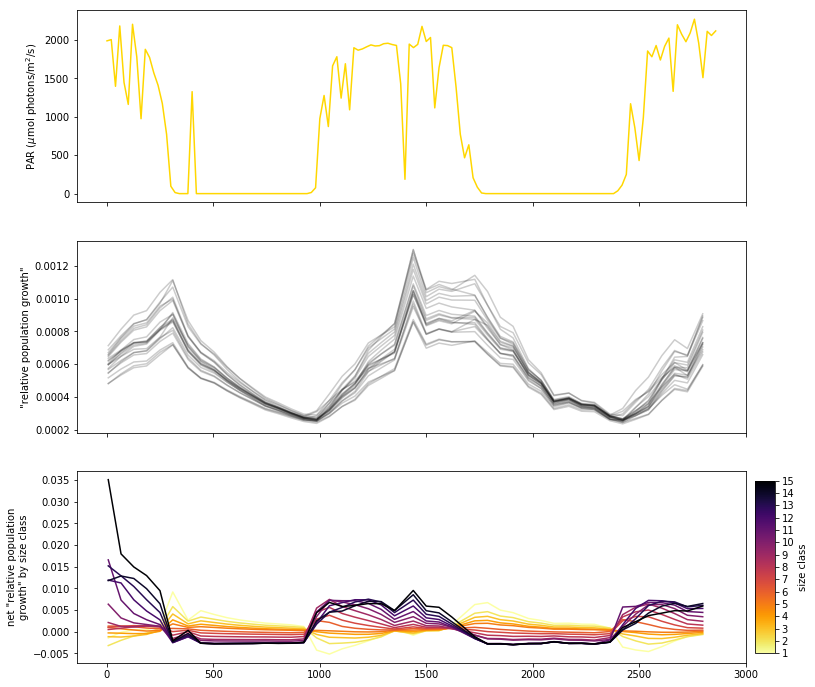

In [10]:
import matplotlib as mpl

# get some posterior samples for relative increase in population per unit time 
num_samples = 20
t = data['t_obs']
dpopdt = np.zeros((num_samples, len(t)-1))

for i in range(num_samples):
    tmp = np.sum(mcmc[name]['mod_obspos'][i,...], axis=0)
    dpopdt[i,:] = (tmp[1:]-tmp[:-1])/tmp[:-1]/(t[1:]-t[:-1])

# mean by size class
dpopdt2 = np.zeros((data['m'], len(t)-1))
for i in range(data['m']):
    # posterior mean
    tmp = np.mean(mcmc[name]['mod_obspos'][:,i,:], axis=0)
    dpopdt2[i,:] = (tmp[1:]-tmp[:-1])/tmp[:-1]/(t[1:]-t[:-1])
    
fig, axs = plt.subplots(nrows=3,sharex=True,figsize=(12,12))

ax = axs[0]
ax.plot(np.arange(data['nt'])*data['dt'], data['E'], color='gold')
ax.set(ylabel='PAR ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
ax.plot(t[:-1], dpopdt.T, color='black', alpha=0.2)
ax.set(ylabel='"relative population growth"')

cmap = plt.get_cmap('inferno_r')
norm = mpl.colors.Normalize(vmin=1, vmax=data['m'])

ax = axs[2]
for i in range(data['m']):
    ax.plot(t[:-1], dpopdt2[i,:], color=cmap(norm(i+1)))
ax.set(ylabel='net "relative population\ngrowth" by size class')
add_colorbar(ax, label='size class', norm=norm, cmap=cmap, ticks=np.arange(1,data['m']+1))

None